# Naiver Bayes-Klassifikator


Datengrundlage für die folgende Aufgabenstellung ist der Titanic-Datensatz, unter /Data abgelegt.

In dieser Aufgabe sollen Sie einen Klassifikator auf Basis des Bayes-Theorem's selbst implementieren. Wir nehmen für diese Aufgabe an, dass die einzelnen Merkmale unabhängig voneinander sind. Man spricht in der Literatur von einem naiven Bayes-Klassifikator. Formal lässt sich der naive Bayes-Klassifikator wie folgt beschreiben:

Gegeben sei ein Merkmalsvektor $\vec x = (x_1,\dots, x_n)$  bestehend aus $n$ Merkmalen. Des Weiteren sei $L = \{C_1,\dots,C_K\}$ die Menge von möglichen Klassen. Dann berechnet sich nach Bayes die a posteriori Wahrscheinlichkeit 

$p(C_k \vert \vec{x}) = \frac{P(C_k) \ p(\vec{x} \vert C_k)}{p(\vec{x})} \,$ mit $p(\vec x) = \sum_{k\in L} P(C_k) \ p(\vec{x} \vert C_k) .$

Nimmt man an, dass die einzenen Merkmale $x_1,\dots,x_i$ unabhängig voneinander sind, lässt sich die a posteriori Wahrscheinlichkeit wie folgt berechnen:

$p(C_k \vert x_1, \dots, x_n) = \frac{P(C_k) \prod_{i=1}^n p(x_i \vert C_k)}{p(\vec x)}$

Da $p(x)$ für ein gegebenen Merkmalsvektor $\vec x$ konstant ist, und somit die Entscheidung nicht beeinflusst, kann der naive Bayes-Klassifikator wie folgt formuliert werden:

$C_y = \operatorname{argmax}_{k \in L} P(C_k) \prod_{i=1}^n p(x_i \vert C_k)$ 


Ziel dieser Aufgabe ist einen solchen naiven Bayes-Klassifikator für die konkrete Anwendung zu implementieren. Idealerweise verwendet man dafür einen großen Datensatz. Für das Verständnis des Algorithmus erfolgt die Implementierung anhand des bereits bekannten Titanic-Datensatzes. 

## 1.) Vorbereitungen


In [1]:
import numpy as np
import csv as csv
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import math
DATA_FILE = './Data/original_titanic.csv'
df = pd.read_csv(DATA_FILE, header=0)

Gerne können Sie zum Füllen der Datenlücken auch Ihre Implementierung aus den vorherigen Aufgabe einsetzen...

In [2]:
def prepareData(df):
    df.loc[(df.Age.isnull()) & (df.Sex == 'male'),'Age'] = df[df.Sex == 'male'].median()
    df.loc[(df.Age.isnull()) & (df.Sex == 'female'),'Age'] = df[df.Sex == 'female'].median()
    df.loc[df.Age.isnull(),'Age']= df.Age.median()
    return df
df = prepareData(df)

## 1.1) A Priori Wahrscheinlichkeiten
Bestimmen Sie die A-Priori Wahrscheinlichkeiten $P(C_{survived})$ sowie $P(C_{\neg survived})$ anhand der Stichprobe.

In [3]:
aPrioriSurvived = (df[['Survived']][(df.Survived == 1)].count()/df.Survived.count())
print(aPrioriSurvived)

aPrioriNotSurvived = (df[['Survived']][(df.Survived == 0)].count()/df.Survived.count())
print(aPrioriNotSurvived)

Survived    0.381971
dtype: float64
Survived    0.618029
dtype: float64


## 1.2) Klassenbedingte Wahrscheinlichkeiten (likelihood)
Ziel dieser Aufgabe ist es die klassenbedingten Wahrscheinlichkeiten $p(\vec{x} \vert C_k)$ für die Merkmale *Age, Fare, Sex und Pclass* zu bestimmen.

### Quantitative Merkmale
Im folgenden sollen die Parameter der normalverteilen Wahrscheinlichkeitsdichtefunktion (WDF) für die Merkmal *Age* und *Fare* geschätzt werden. 

Visualisieren Sie zuerst die diskrete klassenbedingte Verteilung des Merkmales *Fare*.

array([[<AxesSubplot:title={'center':'Fare'}>]], dtype=object)

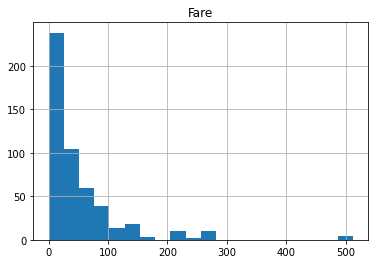

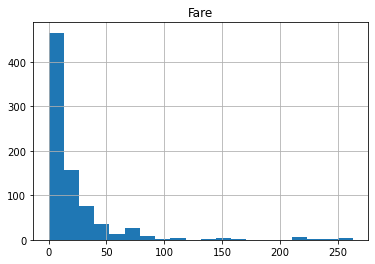

In [20]:
df[['Fare']][(df.Survived == 1)].hist(bins=20)
df[['Fare']][(df.Survived == 0)].hist(bins=20)

Schätzen Sie die Parameter der klassenbedingten Wahrscheinlichkeitsdichtefunktion $p(Fare \vert C_{survived}),p(Fare \vert C_{\neg survived})$ (Maximum-Likelihood Methode). Gehen Sie dabei von einer Normalverteilung aus. Visualisieren Sie die WDFs. Wie bewerten Sie die Trennungswirksamkeit dieses Merkmales?


Dichtefunktion:$ \frac{1}{\sqrt{2\pi\sigma^2}} exp \{- \frac{(x-\mu)^2}{2\sigma^2} \} $

In [5]:
#define a generic gaussian function.
def gaussian(x, mu, sig):
    v = 1/(math.sqrt(2*math.pi*(sig**2)))
    return v*math.e**(-((x-mu)**2)/(2*sig**2))
    
def pFareSurvived(fare):
    fareDf = df[df.Survived == 1].Fare
    mu = fareDf.mean()
    sig = fareDf.std()
    return gaussian(fare, mu, sig)

def pFareNotSurvived(fare):
    fareDf = df[df.Survived == 0].Fare
    mu = fareDf.mean()
    sig = fareDf.std()
    return  gaussian(fare, mu, sig)

Schätzen Sie analog die Parameter der klassenbedingten Wahrscheinlichkeitsdichtefunktion $p(Age \vert C_{survived}),p(Age \vert C_{\neg survived})$ (Maximum-Likelihood Methode). Gehen Sie auch hier von einer Normalverteilung aus. Visualisieren Sie die WDFs. Wie bewerten Sie die Trennungswirksamkeit dieses Merkmales?

<AxesSubplot:>

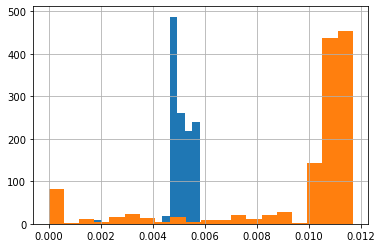

In [21]:
df_copy = df 
df_copy['Fare'].apply(pFareSurvived).hist(bins=20)
df_copy['Fare'].apply(pFareNotSurvived).hist(bins=20)

In [7]:
#pFareNotSurvived(df[df.Survived == 0].Fare).hist()

In [8]:
def pAgeSurvived(age): 
    ageDf = df[df.Survived == 1].Age
    mu = ageDf.mean()
    sig = ageDf.std()
    return gaussian(age, mu, sig)
 
def pAgeNotSurvived(age):    
    ageDf = df[df.Survived == 0].Age
    mu = ageDf.mean()
    sig = ageDf.std()
    return gaussian(age, mu, sig)

<AxesSubplot:>

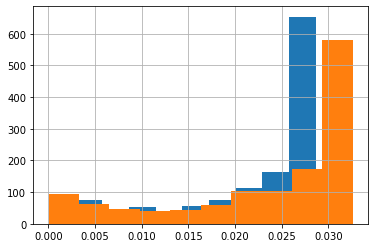

In [9]:
df_copy = df 
df_copy['Age'].apply(pAgeSurvived).hist()
df_copy['Age'].apply(pAgeNotSurvived).hist()

### Kategoriale Merkmale
In dem vorliegenden Datensatz sind einige kategoriale (qualitative) Merkmale enthalten. Da die klassenbedingten Wahrscheinlichkeiten für diese Merkmale nicht mit kontinuierlichen Dichtefunktionen geschätzt werden können, wird die relative Häufigkeit eingesetzt.


Visualisieren sie die absolute Häufigkeiten für das Merkmal *Pclass* für die Klassenzugehörigkeit *Survived* und *Not Survived*. 




array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

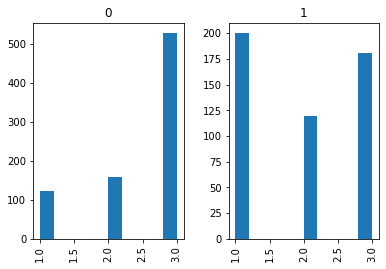

In [10]:
df.Pclass.hist(by=df.Survived)

Bestimmen Sie die klassenbedingten Wahrscheinlichkeiten $p(Pclass \vert C_{survived}),p(Pclass \vert C_{\neg survived})$ anhand der entsprechenden relativen Häufigkeiten und geben Sie das Ergebniss aus. Wie bewerten Sie die Trennungswirksamkeit dieses Merkmales?

In [11]:
def pPClassSurvived(x):
    return len(df[(df.Survived == 1) & (df.Pclass == x)])/len(df[df.Survived == 1])

def pPClassNotSurvived(x):
    return len(df[(df.Survived == 0) & (df.Pclass == x)])/len(df[df.Survived == 0])

In [12]:
for pc in (1,2,3):
    print("class %d:  p(Pclass|surv): %f\tp(Pclass|notSurv): %f" % (pc,pPClassSurvived(pc),pPClassNotSurvived(pc)))

class 1:  p(Pclass|surv): 0.400000	p(Pclass|notSurv): 0.152040
class 2:  p(Pclass|surv): 0.238000	p(Pclass|notSurv): 0.195303
class 3:  p(Pclass|surv): 0.362000	p(Pclass|notSurv): 0.652658


Bestimmen sie analog die klassenbedingten Wahrscheinlichkeiten $p(Sex \vert C_{survived}),p(Sex \vert C_{\neg survived})$. Wie bewerten Sie die Trennungswirksamkeit dieses Merkmales?

In [13]:
def pSexSurvived(x):
    return len(df[(df.Survived == 1) & (df.Sex == x)])/len(df[df.Survived == 1])

def pSexNotSurvived(x):
    return len(df[(df.Survived == 0) & (df.Sex == x)])/len(df[df.Survived == 0])

for s in ('male', 'female'):
    print("sex %s:  p(Sex|surv): %f\tp(Sex|notSurv): %f" % (s,pSexSurvived(s),pSexNotSurvived(s)))

sex male:  p(Sex|surv): 0.322000	p(Sex|notSurv): 0.843016
sex female:  p(Sex|surv): 0.678000	p(Sex|notSurv): 0.156984


## 1.3) Klassifikator implementieren

Fügen Sie nun alle Bestandteile für den naiven Bayes-Klassifikator zusammen. Berechnen Sie zuerst die a posteriori Wahrscheinlichkeiten $p(C_k \vert x_1, \dots, x_n) = \frac{P(C_k) \prod_{i=1}^n p(x_i \vert C_k)}{p(\vec x)}$ für die beiden Klassen. Geben Sie die Ergebnisse für einen exemplarischen Merkmalsvektor $\vec x = (x_1,\dots, x_n)$ aus. 

In [14]:
#example feature vector. 
x=dict(Age=25,Sex='female',Pclass=1,Fare=100)

In [15]:
def numeratorPosteriorSurvived(x):
    return aPrioriSurvived * pAgeSurvived(x['Age']) * pSexSurvived(x['Sex']) * pPClassSurvived(x['Pclass']) * pFareSurvived(x['Fare'])

def numeratorPosteriorNotSurvived(x):
    return aPrioriNotSurvived * pAgeNotSurvived(x['Age']) * pSexNotSurvived(x['Sex']) * pPClassNotSurvived(x['Pclass']) * pFareNotSurvived(x['Fare'])

#the evidence is the dominator p(x) of the posterior
def evidence(x):
    return numeratorPosteriorSurvived(x) + numeratorPosteriorNotSurvived(x)
    
def posteriorSurvived(x): 
    return numeratorPosteriorSurvived(x)/evidence(x)                  
    
def posteriorNotSurvived(x):
    return numeratorPosteriorNotSurvived(x)/evidence(x)   

$p(\vec x) = \sum_{k\in L} P(C_k) \ p(\vec{x} \vert C_k)

In [16]:

print("p(survived|x) = %f " % (posteriorSurvived(x) ))
print("p(notSurvived|x) = %f " % (posteriorNotSurvived(x)))

p(survived|x) = 0.968111 
p(notSurvived|x) = 0.031889 


Da $p(\vec x)$ für ein gegebenen Merkmalsvektor $\vec x$ konstant ist und somit die Entscheidung nicht beeinflusst muss $p(\vec x)$ für die finale Klassifikation nicht berechnet werden. Des weiteren wird aus nummerischen Gründen typischerweise der Logarithmus der Wahrscheinlichkeiten eingesetzt (https://en.wikipedia.org/wiki/Log_probability).

Der naive Bayes-Klassifikator läst sich somit auch wie folgt formulieren:

\begin{equation}
\begin{aligned}
C_y &= \operatorname{argmax}_{k \in L} \log{( P(C_k) \prod_{i=1}^n p(x_i \vert C_k))} \\
    &= \operatorname{argmax}_{k \in L}  \log{P(C_k)} + \sum_{i=1}^n \log{p(x_i \vert C_k)}
\end{aligned}
\end{equation}


Implementieren und testen Sie die entsprechende Entscheidungsfunktion.

In [17]:
def logPosteriorSurvived(x):      
    return math.log(numeratorPosteriorSurvived(x))
    
def logPosteriorNotSurvived(x):   
    return math.log(numeratorPosteriorNotSurvived(x))
    
def predict(x):
    return int(logPosteriorSurvived(x) > logPosteriorNotSurvived(x))

In [18]:
predict(x)

1

Wenden Sie den von Ihnen implementierten Algorithmus auf den Datensatz an und ermitteln Sie die Korrektklassifizierungsrate.

In [19]:
trueEntries = 0
falseEntries = 0
truePositive = 0
trueNegative = 0
for index,row in df.iterrows():
    if predict(row) == row.Survived:
        if row.Survived == 1:
            truePositive += 1
        else:
            trueNegative +=1
        trueEntries +=1
    else:
        falseEntries +=1
        
print(trueEntries)
print(truePositive)
print(trueNegative)
print(falseEntries)
print(trueEntries/(trueEntries+falseEntries))

1005
265
740
304
0.7677616501145913
